# Network validation

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import numpy as np
from pathlib import Path
import pandas as pd
import re

class NVIDIANet(nn.Module):
    def __init__(self, num_outputs=1, dropout_rate=0.1):
        super(NVIDIANet, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 24, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(24, 32, kernel_size=5, stride=2)
        self.conv3 = nn.Conv2d(32, 48, kernel_size=5, stride=2)
        self.conv4 = nn.Conv2d(48, 64, kernel_size=3)
        self.conv5 = nn.Conv2d(64, 64, kernel_size=3)
        
        # Dropout layer
        self.dropout = nn.Dropout(p=dropout_rate)
        
        # Dense layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(1152, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 10)
        self.fc4 = nn.Linear(10, num_outputs)
        
    def forward(self, x):
        # Input normalization
        x = x / 255.0
        
        # Convolutional layers with ELU activation and dropout
        x = F.elu(self.conv1(x))
        x = self.dropout(x)
        
        x = F.elu(self.conv2(x))
        x = self.dropout(x)
        
        x = F.elu(self.conv3(x))
        x = self.dropout(x)
        
        x = F.elu(self.conv4(x))
        x = self.dropout(x)
        
        x = F.elu(self.conv5(x))
        x = self.dropout(x)
        
        # Flatten and dense layers
        x = self.flatten(x)
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))
        x = self.fc4(x)
        
        return x

def load_model(model, model_path, device='cuda'):
    """Load a saved model"""
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    return model

class SteeringPredictor:
    def __init__(self, model_path, min_timestamp, device='cuda', max_steering_angle=25.0):
        """
        Initialize the steering predictor
        
        Args:
            model_path (str): Path to the saved model
            min_timestamp (str): Minimum timestamp in format "YYYYMMDD_HHMMSS_microseconds"
            device (str): Device to run inference on ('cuda' or 'cpu')
            max_steering_angle (float): Maximum steering angle in degrees
        """
        self.device = device
        self.max_steering_angle = max_steering_angle
        self.last_steering = 0.0
        self.min_timestamp = min_timestamp
        
        # Initialize and load model
        self.model = NVIDIANet()
        self.model = load_model(self.model, model_path, device)
        
    def extract_timestamp_and_angle(self, filename):
        """Extract timestamp and angle from filename"""
        pattern = r"frame_(\d{8}_\d{6}_\d+)(?:_(-?\d+\.\d+))?\.jpg"
        match = re.match(pattern, filename)
        
        if match:
            timestamp = match.group(1)
            angle = float(match.group(2)) if match.group(2) else None
            return timestamp, angle
        return None, None

    def is_timestamp_valid(self, timestamp):
        """Check if timestamp is greater than or equal to minimum timestamp"""
        return timestamp >= self.min_timestamp

    def preprocess_image(self, img):
        """Preprocess image for neural network"""
        self.original_img = img.copy()
        
        # Crop
        cropped = img[260:440, :]
        
        # Resize
        resized = cv2.resize(cropped, (200, 66))
        
        # Convert to YUV
        yuv = cv2.cvtColor(resized, cv2.COLOR_RGB2YUV)
        
        # Store preprocessed image
        self.preprocessed_img = yuv.copy()
        
        # Prepare for PyTorch (CHW format)
        yuv = yuv.transpose((2, 0, 1))
        yuv = np.ascontiguousarray(yuv)
        
        return torch.from_numpy(yuv).float().unsqueeze(0).to(self.device)
        
    def predict_steering(self, image):
        """Make steering prediction from image"""
        with torch.no_grad():
            steering_pred = self.model(image)
            
        steering_angle = float(steering_pred.cpu().numpy()[0, 0])
        steering_angle = np.clip(steering_angle, -self.max_steering_angle, self.max_steering_angle)
        self.last_steering = steering_angle 
        
        return steering_angle
    
    def process_image_file(self, image_path):
        """Process a single image file and predict steering angle"""
        timestamp, actual_angle = self.extract_timestamp_and_angle(Path(image_path).name)
        
        if timestamp is None or not self.is_timestamp_valid(timestamp):
            return None, None
            
        img = cv2.imread(str(image_path))
        if img is None:
            raise ValueError(f"Could not read image: {image_path}")
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        processed_img = self.preprocess_image(img)
        predicted_angle = self.predict_steering(processed_img)
        
        return predicted_angle, actual_angle

## Retrieve Images

In [4]:
import os
import glob
from typing import List, Tuple

def get_carla_data_files(data_dir: str, min_timestamp: str = "20241209_173218_948893") -> List[Tuple[str, float]]:
    """
    Get all valid training files from the Carla dataset directory and their steering angles.
    
    Args:
        data_dir: Path to the carla_dataset directory
        min_timestamp: Minimum timestamp to include (as string)
    
    Returns:
        List of tuples containing (file_path, steering_angle)
    """
    # Get all jpg files in directory
    pattern = os.path.join(data_dir, "*.jpg")
    all_files = glob.glob(pattern)
    
    valid_files = []
    for file_path in all_files:
        # Get filename without extension
        filename = os.path.basename(file_path)
        parts = filename.split('_')
        
        # Check if filename matches expected pattern
        if len(parts) >= 5 and 'steering' in filename:
            # Extract timestamp and steering
            timestamp = '_'.join(parts[0:3])  # Combine timestamp parts
            try:
                steering = float(parts[-1].replace('.jpg', ''))
                
                # Only include files with timestamp >= min_timestamp
                if timestamp >= min_timestamp:
                    valid_files.append((file_path, steering))
            except ValueError:
                continue  # Skip if steering value can't be converted to float
    
    # Sort by timestamp
    valid_files.sort(key=lambda x: os.path.basename(x[0]).split('_')[0:3])
    
    return valid_files

data_dir = "carla_dataset"
file_pairs = get_carla_data_files(data_dir)

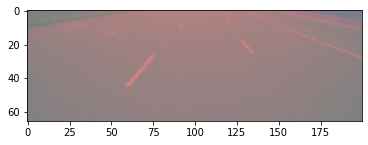

In [5]:
# helper functions
import cv2
def prepare_image_for_neural_network(image_path, crop_top=260, crop_bottom=440):
    """
    Load image, crop, resize, and convert to YUV for neural network processing.
    
    Args:
        image_path: Path to the input image
        
    Returns:
        numpy array in YUV format, size 66x200x3
    """
    # Read and convert image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Crop
    cropped = img_rgb[crop_top:crop_bottom, :]
    
    # Resize to neural network input size (66x200)
    resized = cv2.resize(cropped, (200, 66))
    
    # Convert to YUV
    yuv = cv2.cvtColor(resized, cv2.COLOR_RGB2YUV)

    return yuv

# show the first image is file_pairs
import matplotlib.pyplot as plt
image_path, steering_angle = file_pairs[0]
image = prepare_image_for_neural_network(image_path)
plt.imshow(image)

## Predict

In [6]:
# Load model
model_path = 'best_steering_model_v1.pth'
model = NVIDIANet()
model = load_model(model, model_path)


Actual: 0.0221, Predicted: -0.0006305575370788574


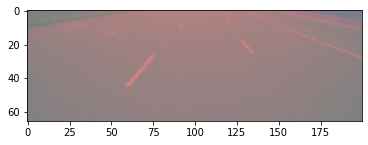

In [12]:
# for file in file_pairs:
#     image_path, steering_angle = file
#     image = prepare_image_for_neural_network(image_path)
#     # Convert to torch tensor and adjust dimensions for PyTorch (CHW instead of HWC)
#     image_tensor = torch.from_numpy(image).float()
#     image_tensor = image_tensor.permute(2, 0, 1)  # Change from HWC to CHW format

#     # Convert steering angle to tensor
#     steering_tensor = torch.tensor(steering_angle, dtype=torch.float32)    
#     #image_tensor = torch.from_numpy(image).float().unsqueeze(0).to('cuda')
#     steering_pred = model(image_tensor)
#     print(f"Actual: {steering_angle}, Predicted: {steering_pred.item()}")
#     break
data_dir = "carla_dataset"
file_pairs = get_carla_data_files(data_dir)
file = file_pairs[0]
image_path, steering_angle = file
image = prepare_image_for_neural_network(image_path)
# plot image
plt.imshow(image)
# Convert to torch tensor and adjust dimensions for PyTorch (CHW instead of HWC)
image_tensor = torch.from_numpy(image).float()
image_tensor = image_tensor.permute(2, 0, 1)  # Change from HWC to CHW format

image_tensor = np.ascontiguousarray(image_tensor)
image_tensor = torch.from_numpy(image_tensor).float().unsqueeze(0).to('cuda')
steering_pred = model(image_tensor)
print(f"Actual: {steering_angle}, Predicted: {steering_pred.item()}")


In [14]:
import torch
import numpy as np
import pandas as pd
from pathlib import Path

# Load model
model_path = 'best_steering_model_v1.pth'
model = NVIDIANet()
model = load_model(model, model_path)

data_dir = "carla_dataset"
output_csv = "steering_predictions.csv"
results = []

# Get all valid files
file_pairs = get_carla_data_files(data_dir)
print(f"Processing {len(file_pairs)} files...")

for file in file_pairs:
    image_path, steering_angle = file
    
    # Prepare and process image
    image = prepare_image_for_neural_network(image_path)
    image_tensor = torch.from_numpy(image).float()
    image_tensor = image_tensor.permute(2, 0, 1)
    image_tensor = np.ascontiguousarray(image_tensor)
    image_tensor = torch.from_numpy(image_tensor).float().unsqueeze(0).to('cuda')
    
    # Get prediction
    steering_pred = model(image_tensor)
    predicted_angle = steering_pred.item()
    
    # Calculate differences
    steering_diff = abs(steering_angle - predicted_angle)
    steering_diff_degrees = steering_diff * 70  # Scale from [-1,1] to [-70,70]
    
    # Store results
    results.append({
        'filename': Path(image_path).name,
        'actual_steering': steering_angle,
        'predicted_steering': predicted_angle,
        'steering_diff': steering_diff,
        'steering_diff_degrees': steering_diff_degrees
    })

# Create DataFrame and save to CSV
df = pd.DataFrame(results)
df.to_csv(output_csv, index=False)

# Print average steering difference in degrees
avg_diff_degrees = df['steering_diff_degrees'].mean()
print(f"\nAverage steering angle difference: {avg_diff_degrees:.2f} degrees")

# Processing 15306 files...

# Average steering angle difference: 0.70 degrees

Processing 15306 files...

Average steering angle difference: 0.70 degrees


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import numpy as np
from pathlib import Path
import pandas as pd
import re
from datetime import datetime

class SteeringPredictor:
    def __init__(self, model_path, min_timestamp, device='cuda', max_steering_angle=25.0):
        """
        Initialize the steering predictor
        
        Args:
            model_path (str): Path to the saved model
            min_timestamp (str): Minimum timestamp in format "YYYYMMDD_HHMMSS_microseconds"
            device (str): Device to run inference on ('cuda' or 'cpu')
            max_steering_angle (float): Maximum steering angle in degrees
        """
        self.device = device
        self.max_steering_angle = max_steering_angle
        self.last_steering = 0.0
        self.min_timestamp = min_timestamp
        
        # Initialize and load model
        self.model = NVIDIANet()
        self.model = load_model(self.model, model_path, device)
        
    def extract_timestamp_and_angle(self, filename):
        """
        Extract timestamp and angle from filename
        
        Args:
            filename (str): Filename in format "frame_YYYYMMDD_HHMMSS_microseconds_angle.jpg"
            
        Returns:
            tuple: (timestamp string, angle float or None)
        """
        # Extract timestamp and angle using regex
        pattern = r"frame_(\d{8}_\d{6}_\d+)(?:_(-?\d+\.\d+))?\.jpg"
        match = re.match(pattern, filename)
        
        if match:
            timestamp = match.group(1)
            angle = float(match.group(2)) if match.group(2) else None
            return timestamp, angle
        return None, None

    def is_timestamp_valid(self, timestamp):
        """
        Check if timestamp is greater than or equal to minimum timestamp
        
        Args:
            timestamp (str): Timestamp to check
            
        Returns:
            bool: True if timestamp is valid, False otherwise
        """
        return timestamp >= self.min_timestamp

    def preprocess_image(self, img):
        """Preprocess image for neural network"""
        # Store original image for display
        self.original_img = img.copy()
        
        # Crop
        cropped = img[260:440, :]
        
        # Resize
        resized = cv2.resize(cropped, (200, 66))
        
        # Convert to YUV
        yuv = cv2.cvtColor(resized, cv2.COLOR_RGB2YUV)
        
        # Store preprocessed image for display
        self.preprocessed_img = yuv.copy()
        
        # Prepare for PyTorch (CHW format)
        yuv = yuv.transpose((2, 0, 1))
        yuv = np.ascontiguousarray(yuv)
        
        return torch.from_numpy(yuv).float().unsqueeze(0).to(self.device)
        
    def predict_steering(self, image):
        """Make steering prediction from image"""
        with torch.no_grad():
            steering_pred = self.model(image)
            
        # Get steering angle from prediction
        steering_angle = float(steering_pred.cpu().numpy()[0, 0])
        
        # Clip and smooth steering
        steering_angle = np.clip(steering_angle, -self.max_steering_angle, self.max_steering_angle)
        self.last_steering = steering_angle 
        
        return steering_angle
    
    def process_image_file(self, image_path):
        """
        Process a single image file and predict steering angle
        
        Args:
            image_path (str): Path to the image file
            
        Returns:
            tuple: (predicted steering angle, actual steering angle if available)
        """
        # Extract timestamp and actual angle from filename
        timestamp, actual_angle = self.extract_timestamp_and_angle(Path(image_path).name)
        
        if timestamp is None or not self.is_timestamp_valid(timestamp):
            return None, None
            
        # Read image
        img = cv2.imread(str(image_path))
        if img is None:
            raise ValueError(f"Could not read image: {image_path}")
        
        # Convert BGR to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Preprocess image
        processed_img = self.preprocess_image(img)
        
        # Predict steering angle
        predicted_angle = self.predict_steering(processed_img)
        
        return predicted_angle, actual_angle
    
    def process_directory(self, directory_path, output_csv=None):
        """
        Process all images in a directory and optionally save results to CSV
        
        Args:
            directory_path (str): Path to directory containing images
            output_csv (str): Optional path to save results CSV
            
        Returns:
            pandas.DataFrame: DataFrame containing results
        """
        directory = Path(directory_path)
        results = []
        
        # Process all jpg files in directory
        for image_path in sorted(directory.glob("*.jpg")):
            try:
                timestamp, actual_angle = self.extract_timestamp_and_angle(image_path.name)
                if timestamp is None or not self.is_timestamp_valid(timestamp):
                    continue
                    
                predicted_angle, actual_angle = self.process_image_file(image_path)
                if predicted_angle is not None:
                    results.append({
                        'filename': image_path.name,
                        'timestamp': timestamp,
                        'predicted_angle': predicted_angle,
                        'actual_angle': actual_angle
                    })
            except Exception as e:
                print(f"Error processing {image_path}: {e}")
        
        # Create DataFrame from results
        df = pd.DataFrame(results)
        
        # Save to CSV if output path provided
        if output_csv:
            df.to_csv(output_csv, index=False)
            print(f"Results saved to {output_csv}")
            
        return df

# Usage example:
if __name__ == "__main__":
    # Initialize predictor with minimum timestamp
    predictor = SteeringPredictor(
        model_path="best_steering_model_v1.pth",
        min_timestamp="20241209_173218_948893",
        device='cuda' if torch.cuda.is_available() else 'cpu'
    )
    
    # Process directory and save results to CSV
    results_df = predictor.process_directory(
        "carla-dataset",
        output_csv="steering_predictions.csv"
    )
    
    # Print summary statistics
    print("\nPrediction Summary:")
    print(f"Total images processed: {len(results_df)}")
    if 'actual_angle' in results_df.columns and results_df['actual_angle'].notna().any():
        mean_error = np.mean(np.abs(
            results_df['predicted_angle'] - results_df['actual_angle'].fillna(0)
        ))
        print(f"Mean absolute error: {mean_error:.2f} degrees")
    print(f"Mean predicted angle: {results_df['predicted_angle'].mean():.2f} degrees")
    print(f"Std predicted angle: {results_df['predicted_angle'].std():.2f} degrees")

Results saved to steering_predictions.csv

Prediction Summary:
Total images processed: 1
Mean absolute error: 15.51 degrees
Mean predicted angle: -0.01 degrees
Std predicted angle: nan degrees


## Unit test

In [20]:
import unittest
import torch
import numpy as np
from pathlib import Path
import cv2
import glob
import os
import pandas as pd
#from SteeringPredictor import SteeringPredictor

def get_image_files(data_dir: str, min_timestamp: str) -> list:
    """
    Get all valid image files from the dataset directory with timestamp >= min_timestamp
    
    Args:
        data_dir: Path to the dataset directory
        min_timestamp: Minimum timestamp to include
        
    Returns:
        List of valid file paths
    """
    pattern = os.path.join(data_dir, "*.jpg")
    all_files = glob.glob(pattern)
    print(f"\nTotal files found in directory: {len(all_files)}")
    
    valid_files = []
    for file_path in sorted(all_files):
        # Get filename without extension
        filename = os.path.basename(file_path)
        parts = filename.split('_')
        
        print(f"\nProcessing file: {filename}")
        print(f"Parts: {parts}")
        
        # Check if filename matches expected pattern
        if len(parts) >= 4:  # At least frame_YYYYMMDD_HHMMSS_microseconds
            # Extract timestamp
            timestamp = '_'.join(parts[1:4])  # Combine timestamp parts
            print(f"Extracted timestamp: {timestamp}")
            print(f"Min timestamp: {min_timestamp}")
            print(f"Is valid: {timestamp >= min_timestamp}")
            
            # Only include files with timestamp >= min_timestamp
            if timestamp >= min_timestamp:
                valid_files.append(file_path)
                print("File added to valid files list")
    
    print(f"\nTotal valid files found: {len(valid_files)}")
    return valid_files

class TestSteeringPredictor(unittest.TestCase):
    @classmethod
    def setUpClass(cls):
        """Set up any necessary test fixtures that can be reused"""
        cls.model_path = "best_steering_model_v1.pth"
        cls.min_timestamp = "20241209_173218_948893"
        cls.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        cls.data_dir = "carla-dataset"
        cls.output_csv = "steering_predictions.csv"
    
    def setUp(self):
        """Set up test instance"""
        self.predictor = SteeringPredictor(
            model_path=self.model_path,
            min_timestamp=self.min_timestamp,
            device=self.device
        )
    
    def test_batch_prediction(self):
        """Test prediction on multiple images"""
        print("\nStarting batch prediction test...")
        
        # Get list of valid files
        image_files = get_image_files(self.data_dir, self.min_timestamp)
        self.assertGreater(len(image_files), 0, "No valid images found")
        
        print("\nProcessing files:")
        # Process each file
        results = []
        for image_path in image_files:
            print(f"\nProcessing: {os.path.basename(image_path)}")
            predicted_angle, actual_angle = self.predictor.process_image_file(image_path)
            print(f"Predicted angle: {predicted_angle}, Actual angle: {actual_angle}")
            
            if predicted_angle is not None:
                # Extract timestamp from filename
                filename = os.path.basename(image_path)
                timestamp = '_'.join(filename.split('_')[1:4])
                
                results.append({
                    'filename': filename,
                    'timestamp': timestamp,
                    'predicted_angle': predicted_angle,
                    'actual_angle': actual_angle
                })
        
        # Convert to DataFrame and save
        df = pd.DataFrame(results)
        df.to_csv(self.output_csv, index=False)
        
        # Verify results
        self.assertGreater(len(df), 0, "No predictions were made")
        for _, row in df.iterrows():
            self.assertLessEqual(
                abs(row['predicted_angle']), 
                self.predictor.max_steering_angle,
                "Predicted angle exceeds maximum"
            )
        
        print(f"\nProcessed {len(df)} images")
        print(f"Results saved to {self.output_csv}")
        print("\nSummary statistics:")
        print(f"Mean predicted angle: {df['predicted_angle'].mean():.2f}°")
        print(f"Std predicted angle: {df['predicted_angle'].std():.2f}°")
        if not df['actual_angle'].isna().all():
            mean_error = np.mean(np.abs(
                df['predicted_angle'] - df['actual_angle'].fillna(0)
            ))
            print(f"Mean absolute error: {mean_error:.2f}°")

if __name__ == '__main__':
    # Run only the batch prediction test
    suite = unittest.TestSuite()
    suite.addTest(TestSteeringPredictor('test_batch_prediction'))
    unittest.TextTestRunner(verbosity=2).run(suite)

test_batch_prediction (__main__.TestSteeringPredictor)
Test prediction on multiple images ... 


Starting batch prediction test...

Total files found in directory: 1

Processing file: frame_20241210_173218_948893_15.5.jpg
Parts: ['frame', '20241210', '173218', '948893', '15.5.jpg']
Extracted timestamp: 20241210_173218_948893
Min timestamp: 20241209_173218_948893
Is valid: True
File added to valid files list

Total valid files found: 1

Processing files:

Processing: frame_20241210_173218_948893_15.5.jpg
Predicted angle: -0.008069038391113281, Actual angle: 15.5

Processed 1 images
Results saved to steering_predictions.csv

Summary statistics:
Mean predicted angle: -0.01°
Std predicted angle: nan°
Mean absolute error: 15.51°


ok

----------------------------------------------------------------------
Ran 1 test in 0.126s

OK


## prediction simple script

In [35]:
import os
import glob
from typing import List, Tuple
import pandas as pd
#from SteeringPredictor import SteeringPredictor

def get_carla_data_files(data_dir: str, min_timestamp: str = "20241209_173218_948893") -> List[Tuple[str, float]]:
    """
    Get all valid training files from the Carla dataset directory and their steering angles.
    Args:
        data_dir: Path to the carla_dataset directory
        min_timestamp: Minimum timestamp to include (as string)
    Returns:
        List of tuples containing (file_path, steering_angle)
    """
    # Get all jpg files in directory
    pattern = os.path.join(data_dir, "*.jpg")
    all_files = glob.glob(pattern)
    
    valid_files = []
    for file_path in all_files:
        # Get filename without extension
        filename = os.path.basename(file_path)
        parts = filename.split('_')
        
        # Check if filename matches expected pattern
        if len(parts) >= 5 and 'steering' in filename:
            # Extract timestamp and steering
            timestamp = '_'.join(parts[0:3])  # Combine timestamp parts
            try:
                steering = float(parts[-1].replace('.jpg', ''))
                
                # Only include files with timestamp >= min_timestamp
                if timestamp >= min_timestamp:
                    valid_files.append((file_path, steering))
            except ValueError:
                continue  # Skip if steering value can't be converted to float
    
    # Sort by timestamp
    valid_files.sort(key=lambda x: os.path.basename(x[0]).split('_')[0:3])
    return valid_files

# Parameters
data_dir = "carla_dataset"
model_path = "best_steering_model_v1.pth"
min_timestamp = "20241209_173218_948893"
output_csv = "steering_predictions.csv"

# Get valid files
valid_files = get_carla_data_files(data_dir, min_timestamp)
print(f"Found {len(valid_files)} valid files")

# Initialize predictor
predictor = SteeringPredictor(
    model_path=model_path,
    min_timestamp=min_timestamp
)

# Process each file
results = []
for file_path, actual_angle in valid_files:
    print(file_path)
    predicted_angle, _ = predictor.process_image_file(file_path)
    if predicted_angle is not None:  # Valid prediction
        filename = os.path.basename(file_path)
        results.append({
            'filename': filename,
            'predicted_angle': predicted_angle,
            'actual_angle': actual_angle
        })

# Save results
df = pd.DataFrame(results)
df.to_csv(output_csv, index=False)
print(f"\nProcessed {len(results)} images")
print(f"Results saved to {output_csv}")

# Print some statistics
if len(results) > 0:
    print("\nStatistics:")
    print(f"Mean predicted angle: {df['predicted_angle'].mean():.2f}°")
    if 'actual_angle' in df:
        mean_error = (df['predicted_angle'] - df['actual_angle']).abs().mean()
        print(f"Mean absolute error: {mean_error:.2f}°")

Found 15306 valid files
carla_dataset/20241209_173218_948893_steering_0.0221.jpg
carla_dataset/20241209_173218_983379_steering_0.0197.jpg
carla_dataset/20241209_173219_015345_steering_0.0197.jpg
carla_dataset/20241209_173219_048928_steering_0.0197.jpg
carla_dataset/20241209_173219_082877_steering_0.0181.jpg
carla_dataset/20241209_173219_118632_steering_0.0181.jpg
carla_dataset/20241209_173219_151723_steering_0.0181.jpg
carla_dataset/20241209_173219_186379_steering_0.0212.jpg
carla_dataset/20241209_173219_220921_steering_0.0212.jpg
carla_dataset/20241209_173219_253615_steering_0.0212.jpg
carla_dataset/20241209_173219_287463_steering_0.0212.jpg
carla_dataset/20241209_173219_321004_steering_0.0192.jpg
carla_dataset/20241209_173219_354734_steering_0.0192.jpg
carla_dataset/20241209_173219_389484_steering_0.0192.jpg
carla_dataset/20241209_173219_422421_steering_0.0219.jpg
carla_dataset/20241209_173219_457256_steering_0.0219.jpg
carla_dataset/20241209_173219_491339_steering_0.0219.jpg
carla_d

In [36]:
file_path="carla_dataset/20241209_174137_809767_steering_0.0197.jpg"
predictor.process_image_file(file_path)

(None, None)